### Data Dictionary


    Team: A code for the name of the team
    League: The Major League Baseball league the team belongs to, either AL (American League) or NL (National League)
    Year: The year of the corresponding record
    RS: The number of runs scored by the team in that year
    RA: The number of runs allowed by the team in that year
    W: The number of regular season wins by the team in that year
    OBP: The on-base percentage of the team in that year
    SLG: The slugging percentage of the team in that year
    BA: The batting average of the team in that year
    Playoffs: Whether the team made the playoffs in that year (1 for yes, 0 for no)
    RankSeason: Among the playoff teams in that year, the ranking of their regular season records (1 is best)
    RankPlayoffs: Among the playoff teams in that year, how well they fared in the playoffs. The team winning the World Series gets a RankPlayoffs of 1.
    G: The number of games a team played in that year
    OOBP: The team's opponents' on-base percentage in that year
    OSLG: The team's opponents' slugging percentage in that year



In this homework question, we'll use the same data to investigate how well we can predict the World Series winner at the beginning of the playoffs.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("baseball.csv")

In [3]:
df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


In [5]:
df.describe(include='all')

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,1232,1232,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,244.000000,244.000000,1232.000000,420.000000,420.000000
unique,39,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,HOU,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,47,616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,3.122951,2.717213,161.918831,0.332264,0.419743
std,NaN,NaN,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,1.738349,1.095234,0.624365,0.015295,0.026510
min,NaN,NaN,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,1.000000,1.000000,158.000000,0.294000,0.346000
25%,NaN,NaN,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,2.000000,2.000000,162.000000,0.321000,0.401000
50%,NaN,NaN,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,3.000000,3.000000,162.000000,0.331000,0.419000
75%,NaN,NaN,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,4.000000,4.000000,162.000000,0.343000,0.438000


In [6]:
df.shape

(1232, 15)

In [7]:
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'RankSeason', 'RankPlayoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

### Data Visualization

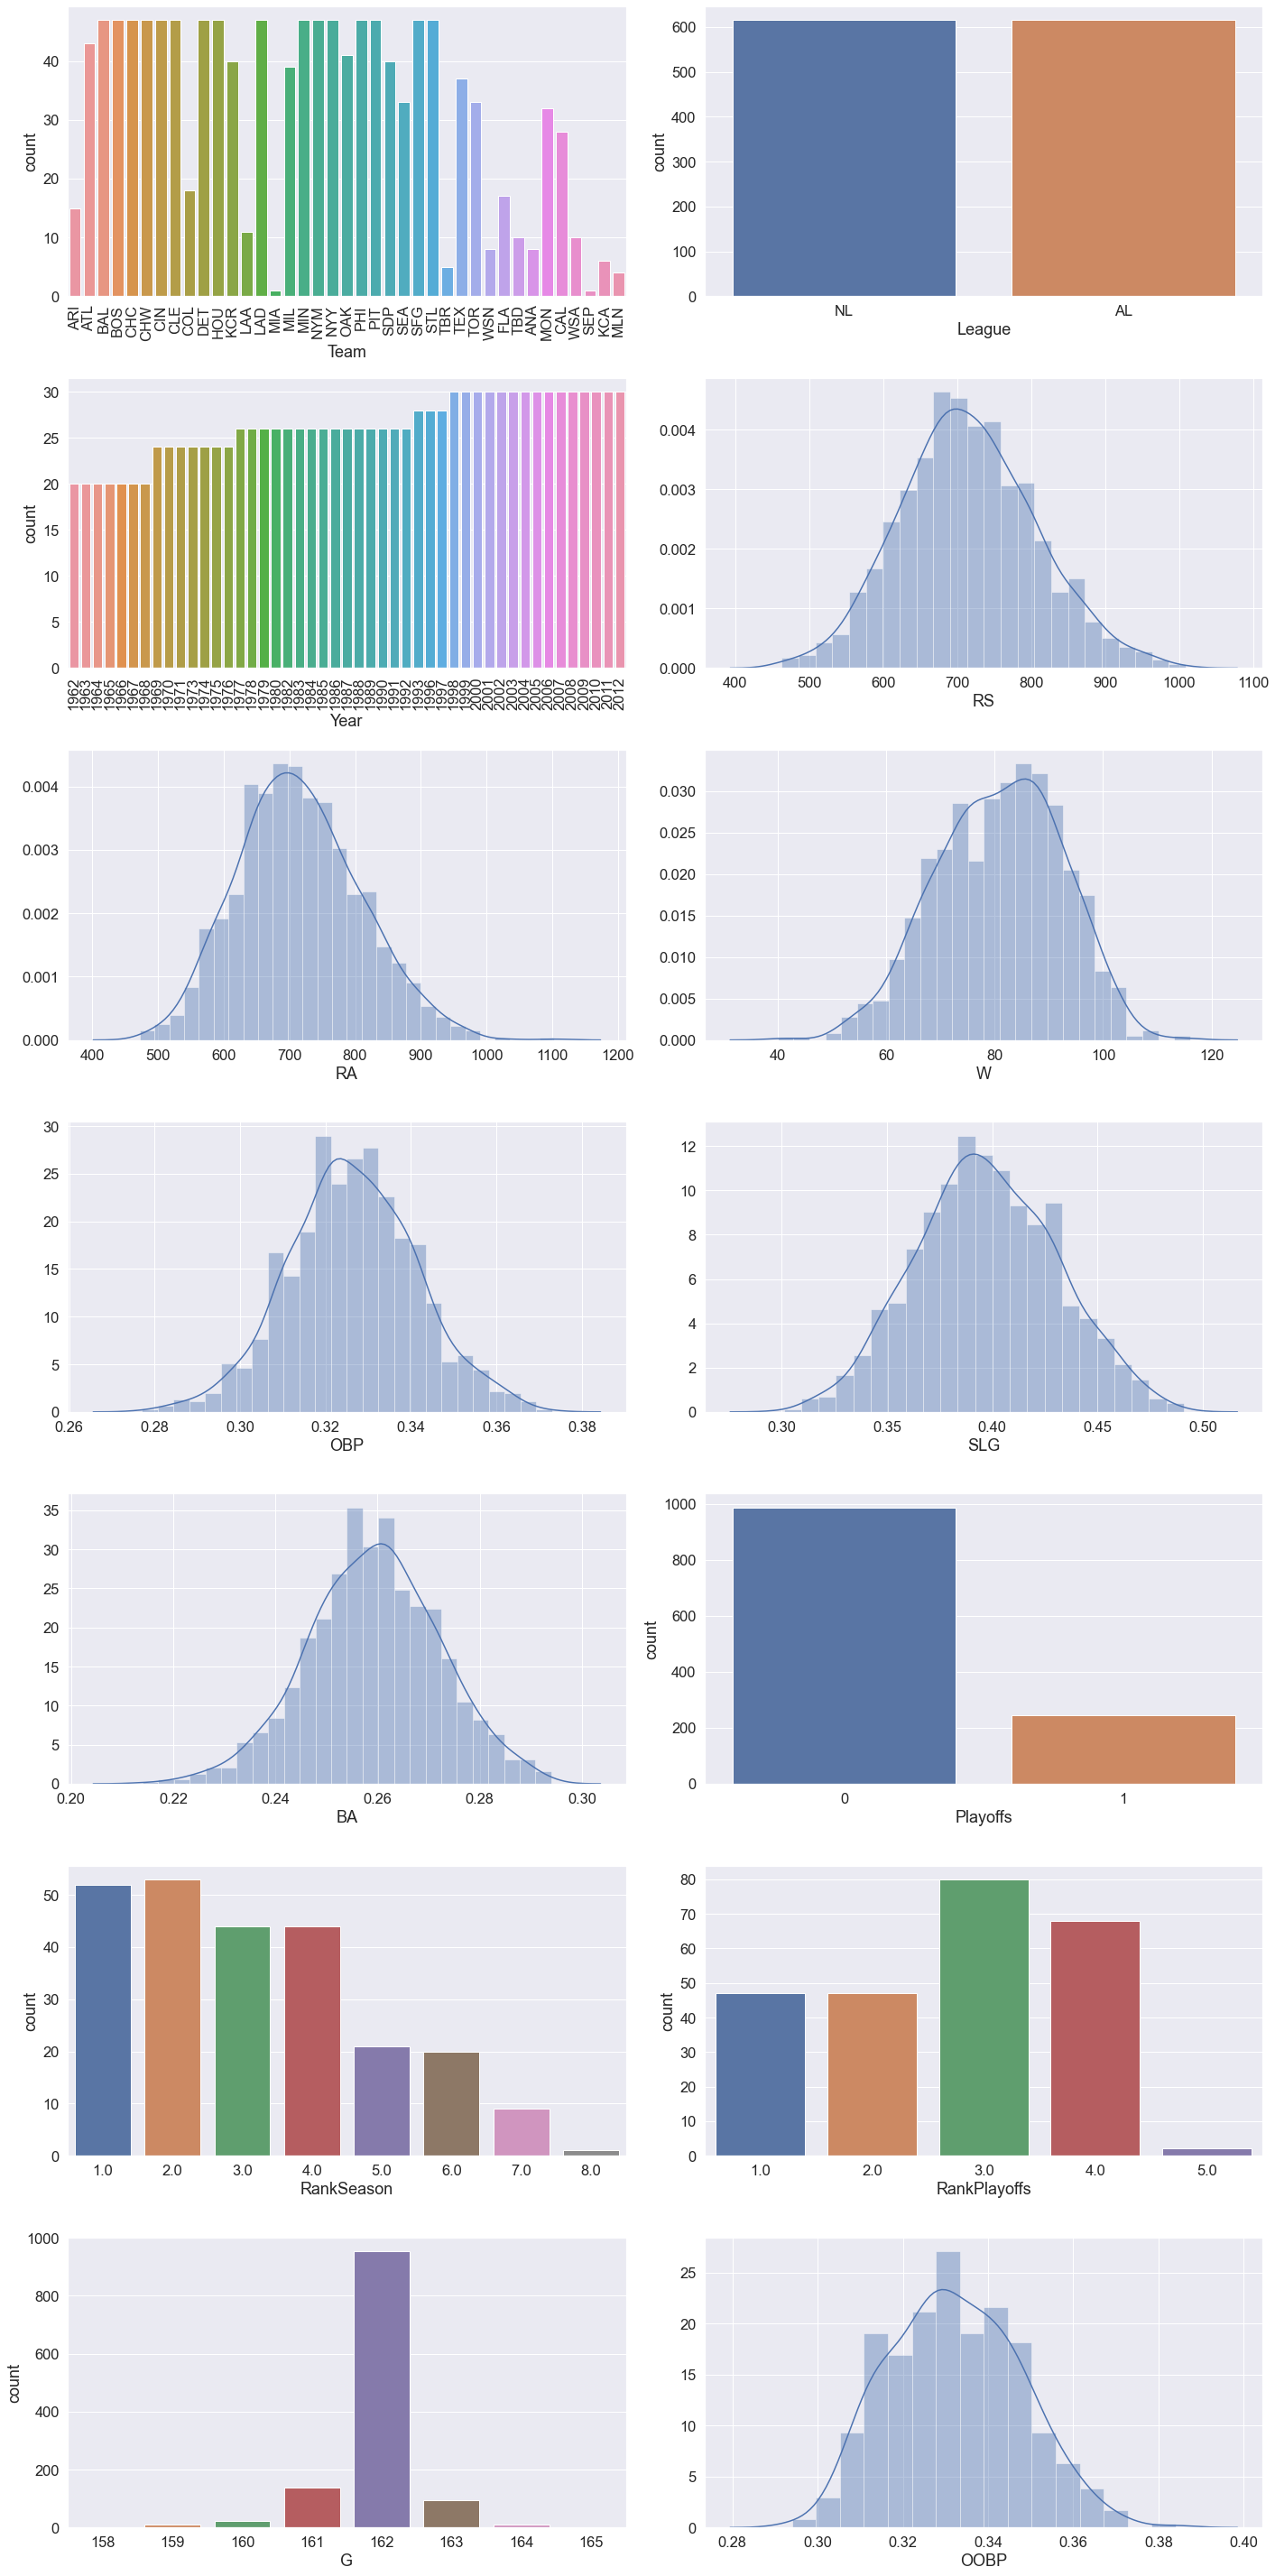

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Team)
plt.xticks(rotation=90)
plt.subplot(7,2,2)
sns.countplot(df.League)
plt.subplot(7,2,3)
sns.countplot(df.Year)
plt.xticks(rotation=90)
plt.subplot(7,2,4)
sns.distplot(df.RS)
plt.subplot(7,2,5)
sns.distplot(df.RA)
plt.subplot(7,2,6)
sns.distplot(df.W)
plt.subplot(7,2,7)
sns.distplot(df.OBP)
plt.subplot(7,2,8)
sns.distplot(df.SLG)
plt.subplot(7,2,9)
sns.distplot(df.BA)
plt.subplot(7,2,10)
sns.countplot(df.Playoffs)
plt.subplot(7,2,11)
sns.countplot(df.RankSeason)
plt.subplot(7,2,12)
sns.countplot(df.RankPlayoffs)
plt.subplot(7,2,13)
sns.countplot(df.G)
plt.subplot(7,2,14)
sns.distplot(df.OOBP)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
Year,1.000000,0.418978,0.412020,0.004138,0.374354,0.536037,0.349397,0.145779,0.385219,0.443967,0.009287,-0.371869,-0.345667
RS,0.418978,1.000000,0.380139,0.511745,0.900492,0.918740,0.827000,0.386628,-0.027687,0.210963,0.075195,0.133981,0.193426
RA,0.412020,0.380139,1.000000,-0.532394,0.326360,0.436527,0.330764,-0.261477,0.399141,0.315128,-0.023369,0.910344,0.909319
W,0.004138,0.511745,-0.532394,1.000000,0.481836,0.401496,0.408716,0.616757,-0.755098,-0.198960,0.105309,-0.634315,-0.568490
OBP,0.374354,0.900492,0.326360,0.481836,1.000000,0.790910,0.851958,0.363890,0.001612,0.175349,0.016563,0.120349,0.153372
SLG,0.536037,0.918740,0.436527,0.401496,0.790910,1.000000,0.790481,0.324713,0.126663,0.271893,0.036770,0.143861,0.210423
BA,0.349397,0.827000,0.330764,0.408716,0.851958,0.790481,1.000000,0.290217,0.035452,0.092684,0.019886,0.187108,0.227808
Playoffs,0.145779,0.386628,-0.261477,0.616757,0.363890,0.324713,0.290217,1.000000,NaN,NaN,0.022208,-0.433572,-0.366744
RankSeason,0.385219,-0.027687,0.399141,-0.755098,0.001612,0.126663,0.035452,NaN,1.000000,0.266906,0.069222,0.097731,0.050111
RankPlayoffs,0.443967,0.210963,0.315128,-0.198960,0.175349,0.271893,0.092684,NaN,0.266906,1.000000,0.007820,0.065808,0.087089


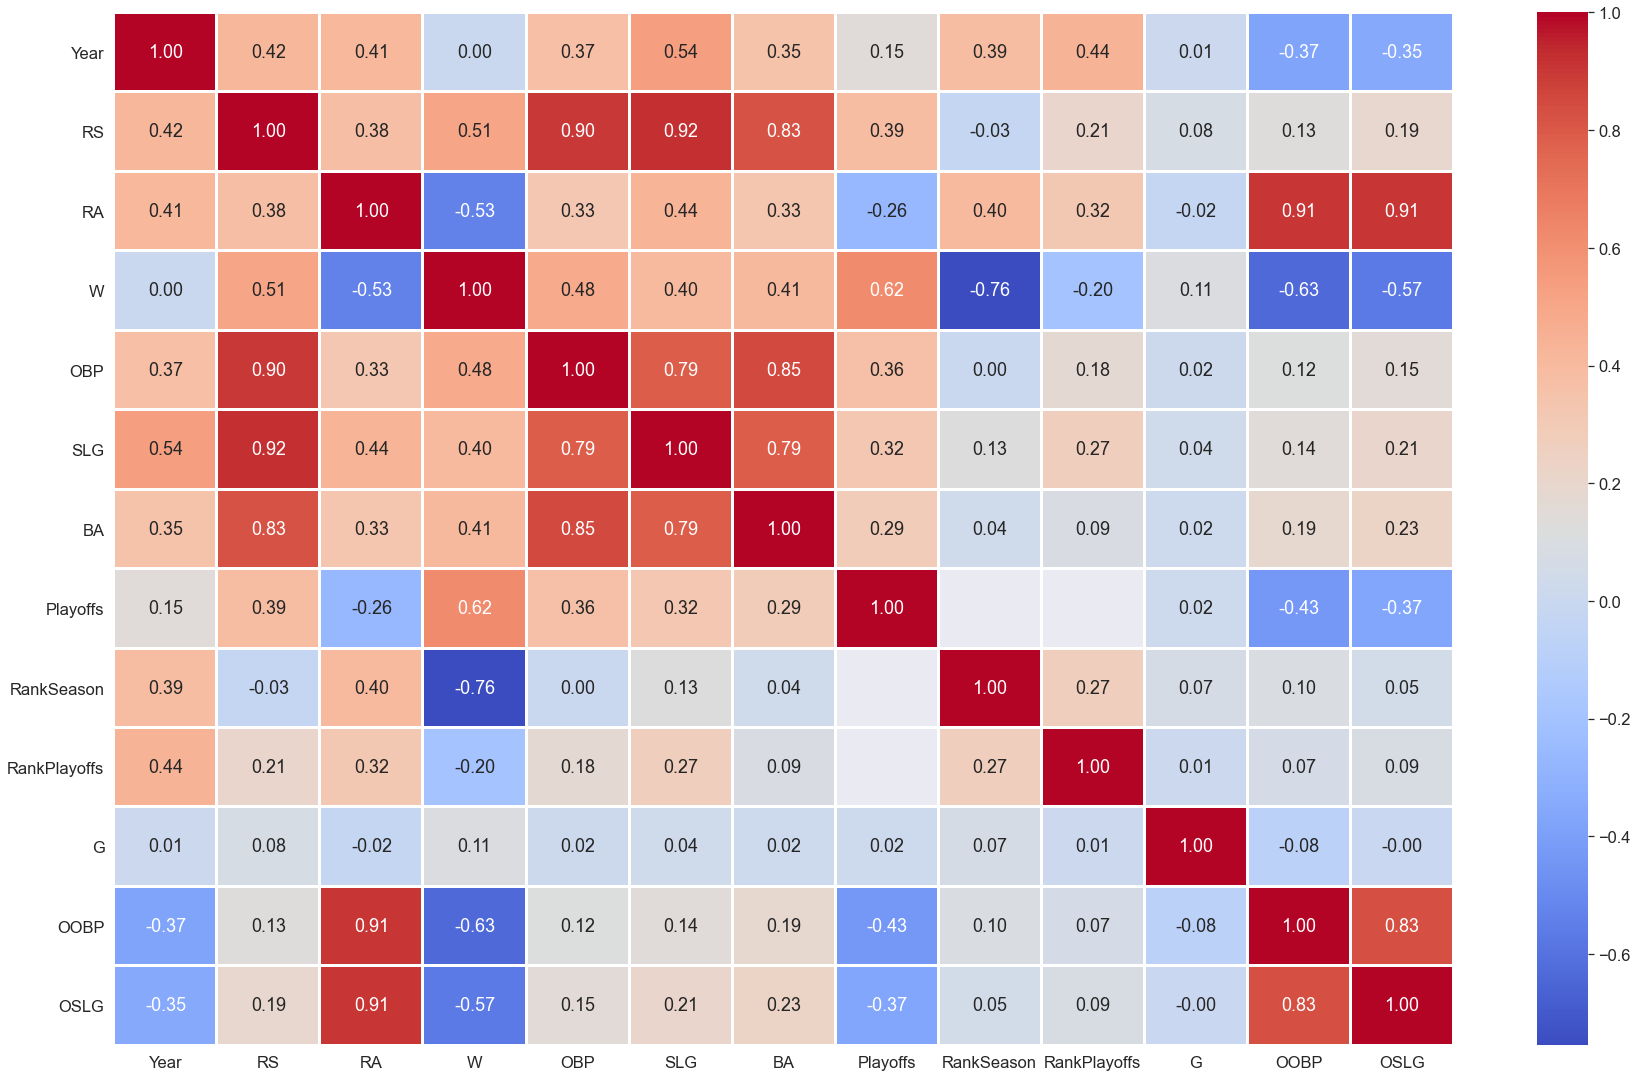

In [10]:
plt.figure(figsize=(30,19))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

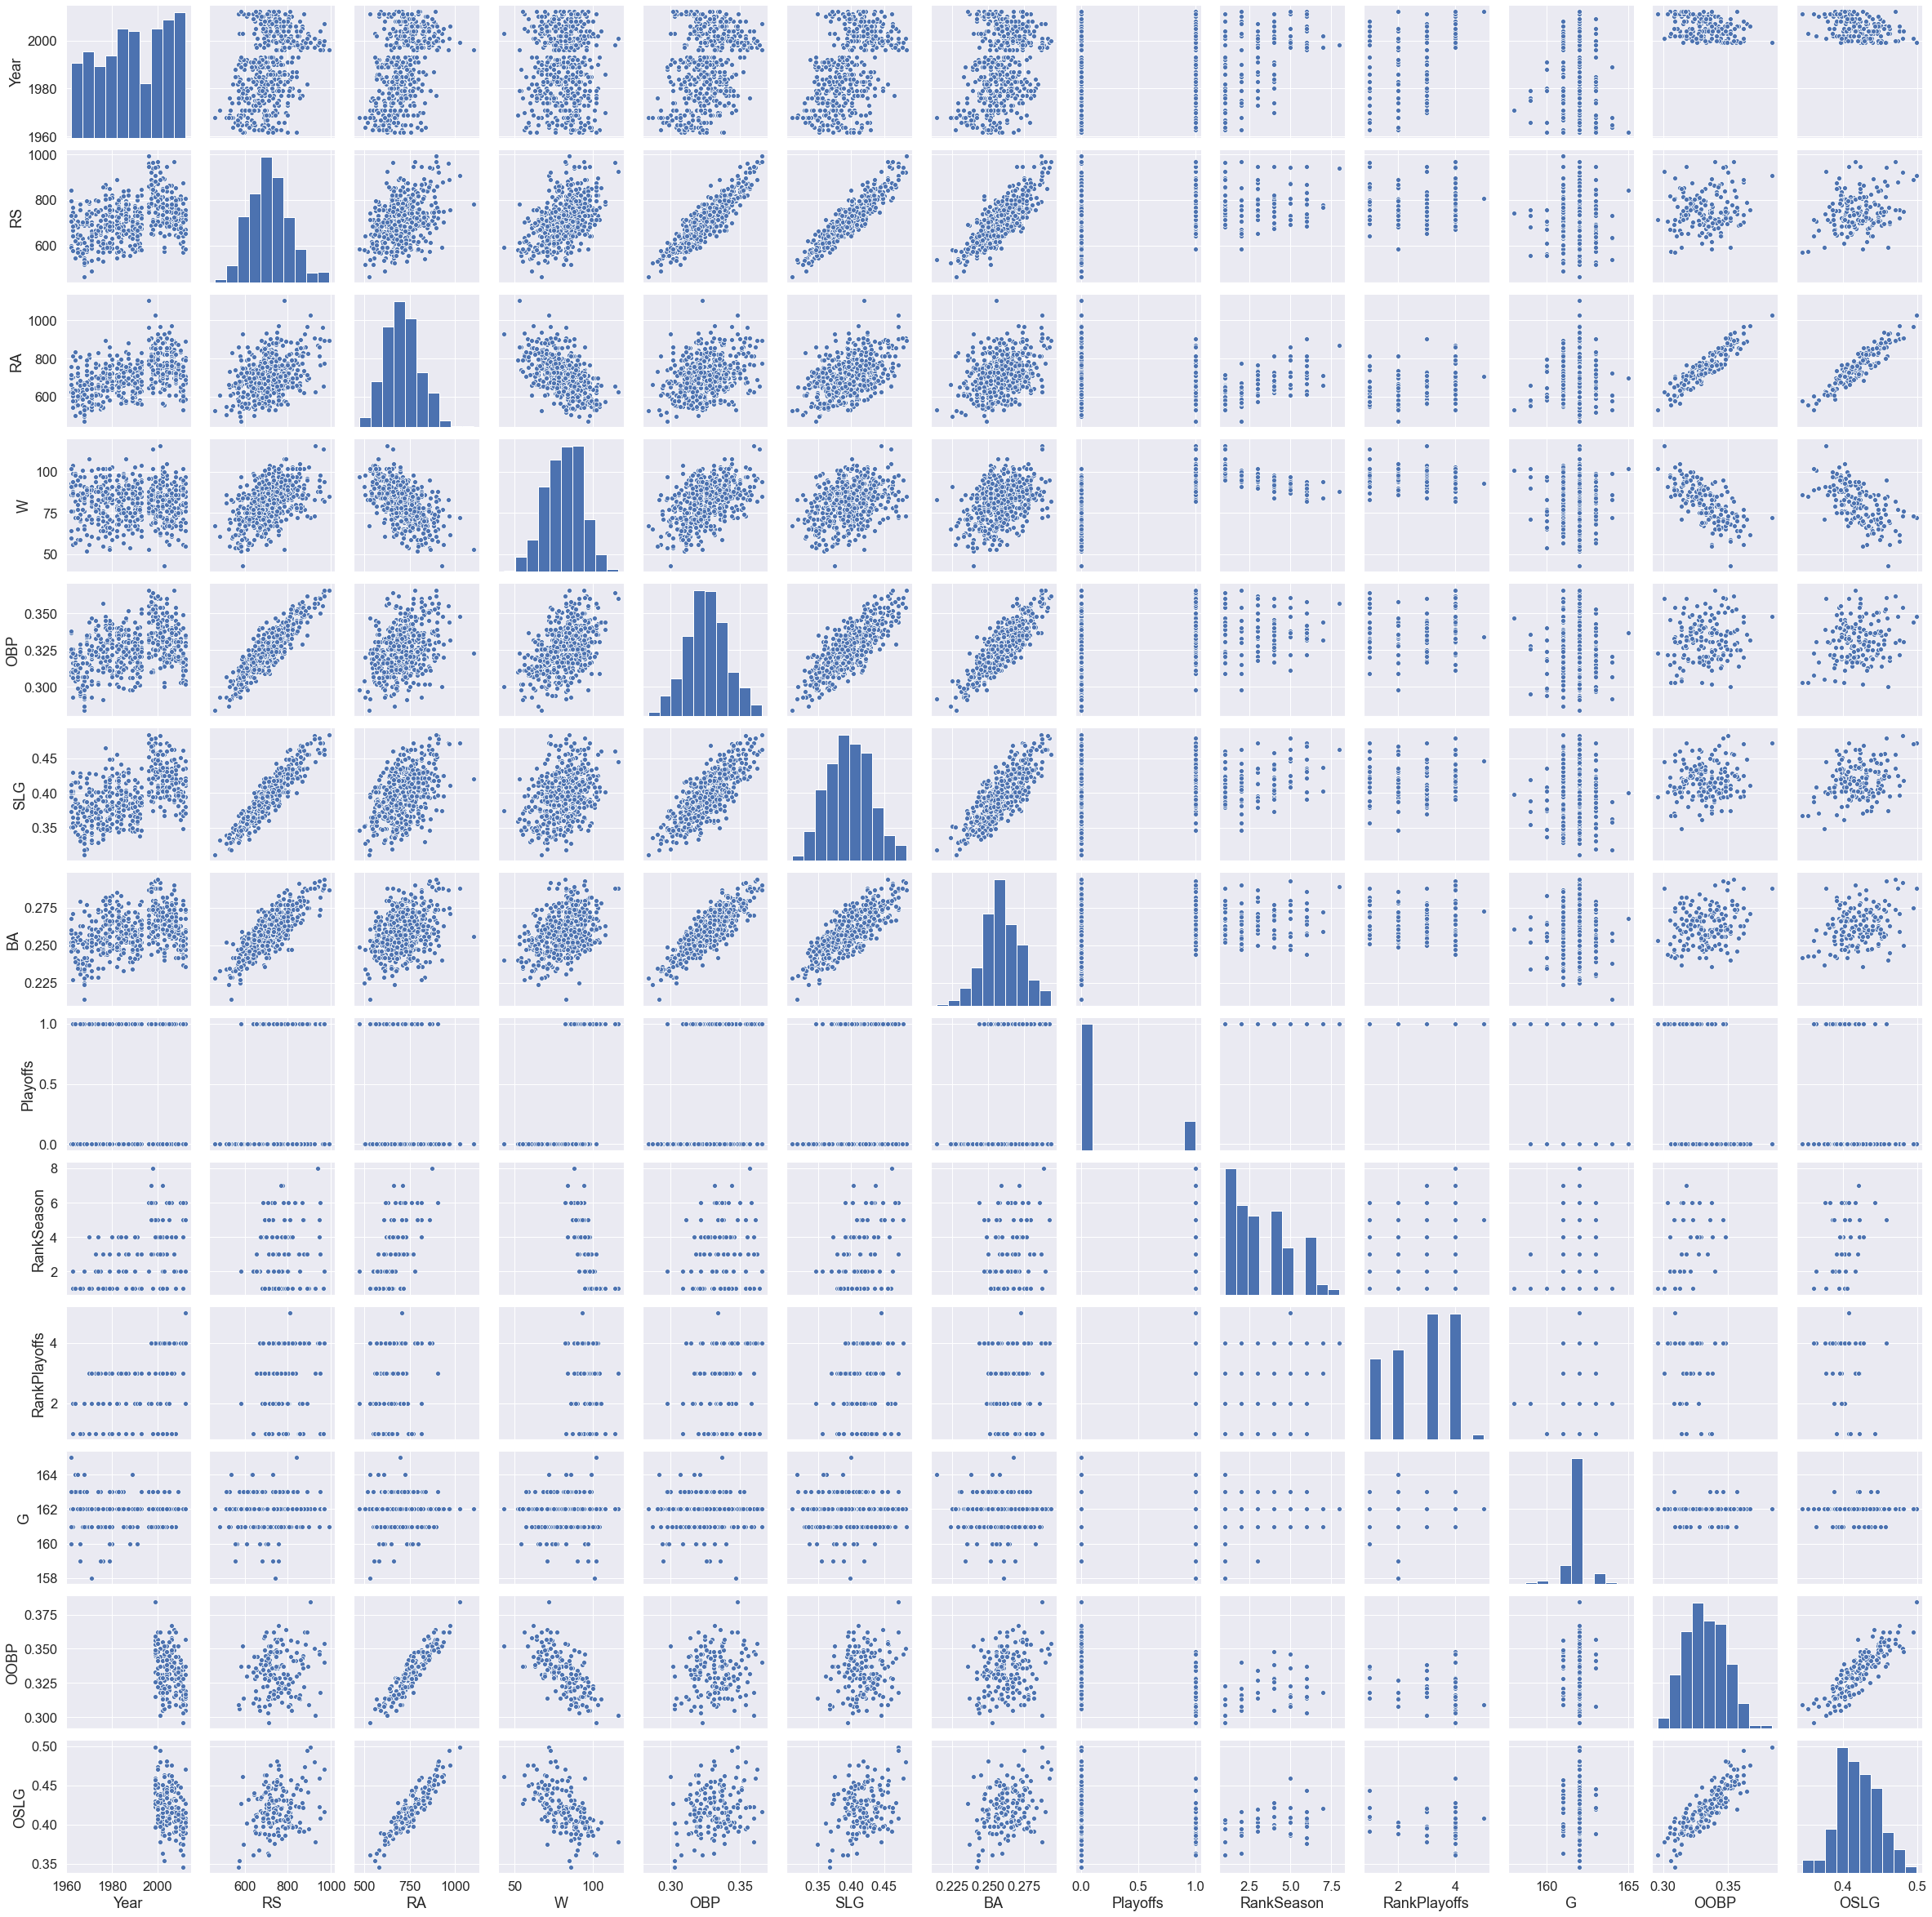

In [11]:
sns.pairplot(df.sample(500))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

In [13]:
df.drop(['Team','League','Year','RankSeason', 'RankPlayoffs','OOBP','OSLG'],axis=1, inplace=True)

In [14]:
df

,RS,RA,W,OBP,SLG,BA,Playoffs,G
0,734,688,81,0.328,0.418,0.259,0,162
1,700,600,94,0.320,0.389,0.247,1,162
2,712,705,93,0.311,0.417,0.247,1,162
3,734,806,69,0.315,0.415,0.260,0,162
4,613,759,61,0.302,0.378,0.240,0,162
...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,0,161
1228,706,626,93,0.321,0.394,0.268,0,161
1229,878,690,103,0.341,0.441,0.278,1,165
1230,774,664,84,0.335,0.394,0.271,0,163


### Treat Duplicate Values

In [15]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

In [18]:
df['Playoffs'].value_counts()

0    988
1    244
Name: Playoffs, dtype: int64

### Treat Outliers

In [19]:
df.describe()

,RS,RA,W,OBP,SLG,BA,Playoffs,G
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,161.918831
std,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,0.624365
min,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,158.000000
25%,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,162.000000
50%,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,162.000000
75%,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,162.000000
max,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,165.000000


In [20]:
df.columns

Index(['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'Playoffs', 'G'], dtype='object')

In [21]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
                         variables=['RS', 'RA', 'W', 'OBP', 'SLG', 'BA'])

In [22]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['RS', 'RA', 'W', 'OBP', 'SLG', 'BA'])

In [23]:
df2 = windsorizer.transform(df)

In [24]:
df2

,RS,RA,W,OBP,SLG,BA,Playoffs,G
0,734.0,688.0,81.0,0.328,0.418,0.259,0,162
1,700.0,600.0,94.0,0.320,0.389,0.247,1,162
2,712.0,705.0,93.0,0.311,0.417,0.247,1,162
3,734.0,806.0,69.0,0.315,0.415,0.260,0,162
4,613.0,759.0,61.0,0.302,0.378,0.240,0,162
...,...,...,...,...,...,...,...,...
1227,705.0,759.0,81.0,0.330,0.390,0.260,0,161
1228,706.0,626.0,93.0,0.321,0.394,0.268,0,161
1229,878.0,690.0,103.0,0.341,0.441,0.278,1,165
1230,774.0,664.0,84.0,0.335,0.394,0.271,0,163


In [25]:
df2.describe()

,RS,RA,W,OBP,SLG,BA,Playoffs,G
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,714.985390,714.869318,80.913149,0.326348,0.397345,0.259300,0.198052,161.918831
std,91.222339,92.405334,11.410504,0.014927,0.033253,0.012826,0.398693,0.624365
min,467.500000,472.000000,49.000000,0.287000,0.306000,0.225500,0.000000,158.000000
25%,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,162.000000
50%,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,162.000000
75%,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,162.000000
max,959.500000,961.000000,113.000000,0.367000,0.490000,0.293500,1.000000,165.000000


In [26]:
windsorizer.left_tail_caps_

{'RS': 467.5,
 'RA': 463.0,
 'W': 49.0,
 'OBP': 0.287,
 'SLG': 0.30599999999999994,
 'BA': 0.22549999999999998}

In [27]:
windsorizer.right_tail_caps_

{'RS': 959.5,
 'RA': 961.0,
 'W': 113.0,
 'OBP': 0.36700000000000005,
 'SLG': 0.4900000000000001,
 'BA': 0.29350000000000004}

### Treat Data Types

### Feature Scaling

In [28]:
df2.columns

Index(['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'Playoffs', 'G'], dtype='object')

In [29]:
df2.shape

(1232, 8)

In [30]:
df2 = df2[['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'G', 'Playoffs']]

In [31]:
df2_num = df2.drop(['Playoffs'],axis=1)

In [32]:
df2_num

,RS,RA,W,OBP,SLG,BA,G
0,734.0,688.0,81.0,0.328,0.418,0.259,162
1,700.0,600.0,94.0,0.320,0.389,0.247,162
2,712.0,705.0,93.0,0.311,0.417,0.247,162
3,734.0,806.0,69.0,0.315,0.415,0.260,162
4,613.0,759.0,61.0,0.302,0.378,0.240,162
...,...,...,...,...,...,...,...
1227,705.0,759.0,81.0,0.330,0.390,0.260,161
1228,706.0,626.0,93.0,0.321,0.394,0.268,161
1229,878.0,690.0,103.0,0.341,0.441,0.278,165
1230,774.0,664.0,84.0,0.335,0.394,0.271,163


In [33]:
maxmin = MinMaxScaler()

In [34]:
df2numeric = maxmin.fit_transform(df2_num)

In [35]:
df2numeric

array([[0.54166667, 0.44171779, 0.5       , ..., 0.60869565, 0.49264706,
        0.57142857],
       [0.47256098, 0.26175869, 0.703125  , ..., 0.45108696, 0.31617647,
        0.57142857],
       [0.49695122, 0.47648262, 0.6875    , ..., 0.60326087, 0.31617647,
        0.57142857],
       ...,
       [0.83434959, 0.44580777, 0.84375   , ..., 0.73369565, 0.77205882,
        1.        ],
       [0.62296748, 0.39263804, 0.546875  , ..., 0.47826087, 0.66911765,
        0.71428571],
       [0.26727642, 0.49897751, 0.171875  , ..., 0.36413043, 0.36029412,
        0.57142857]])

In [36]:
df2numeric = pd.DataFrame(df2numeric,columns=df2_num.columns)

In [37]:
df2numeric

,RS,RA,W,OBP,SLG,BA,G
0,0.541667,0.441718,0.500000,0.5125,0.608696,0.492647,0.571429
1,0.472561,0.261759,0.703125,0.4125,0.451087,0.316176,0.571429
2,0.496951,0.476483,0.687500,0.3000,0.603261,0.316176,0.571429
3,0.541667,0.683027,0.312500,0.3500,0.592391,0.507353,0.571429
4,0.295732,0.586912,0.187500,0.1875,0.391304,0.213235,0.571429
...,...,...,...,...,...,...,...
1227,0.482724,0.586912,0.500000,0.5375,0.456522,0.507353,0.428571
1228,0.484756,0.314928,0.687500,0.4250,0.478261,0.625000,0.428571
1229,0.834350,0.445808,0.843750,0.6750,0.733696,0.772059,1.000000
1230,0.622967,0.392638,0.546875,0.6000,0.478261,0.669118,0.714286


In [38]:
label = df2['Playoffs']

In [39]:
label

0       0
1       1
2       1
3       0
4       0
       ..
1227    0
1228    0
1229    1
1230    0
1231    0
Name: Playoffs, Length: 1232, dtype: int64

In [40]:
df3 = pd.concat([df2numeric,label],axis=1)

In [41]:
df3

,RS,RA,W,OBP,SLG,BA,G,Playoffs
0,0.541667,0.441718,0.500000,0.5125,0.608696,0.492647,0.571429,0
1,0.472561,0.261759,0.703125,0.4125,0.451087,0.316176,0.571429,1
2,0.496951,0.476483,0.687500,0.3000,0.603261,0.316176,0.571429,1
3,0.541667,0.683027,0.312500,0.3500,0.592391,0.507353,0.571429,0
4,0.295732,0.586912,0.187500,0.1875,0.391304,0.213235,0.571429,0
...,...,...,...,...,...,...,...,...
1227,0.482724,0.586912,0.500000,0.5375,0.456522,0.507353,0.428571,0
1228,0.484756,0.314928,0.687500,0.4250,0.478261,0.625000,0.428571,0
1229,0.834350,0.445808,0.843750,0.6750,0.733696,0.772059,1.000000,1
1230,0.622967,0.392638,0.546875,0.6000,0.478261,0.669118,0.714286,0


In [42]:
#Save to csv
#df3.to_csv("baseballtrain.csv",index=False)

### Create and save processed dataset

### Model Training

In [43]:
df3.shape

(1232, 8)

In [44]:
X = df3.iloc[:,0:7]
y = df3.iloc[:,7]

In [45]:
X.values, y.values

(array([[0.54166667, 0.44171779, 0.5       , ..., 0.60869565, 0.49264706,
         0.57142857],
        [0.47256098, 0.26175869, 0.703125  , ..., 0.45108696, 0.31617647,
         0.57142857],
        [0.49695122, 0.47648262, 0.6875    , ..., 0.60326087, 0.31617647,
         0.57142857],
        ...,
        [0.83434959, 0.44580777, 0.84375   , ..., 0.73369565, 0.77205882,
         1.        ],
        [0.62296748, 0.39263804, 0.546875  , ..., 0.47826087, 0.66911765,
         0.71428571],
        [0.26727642, 0.49897751, 0.171875  , ..., 0.36413043, 0.36029412,
         0.57142857]]),
 array([0, 1, 1, ..., 1, 0, 0], dtype=int64))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((985, 7), (247, 7), (985,), (247,))

In [48]:
xgb = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [49]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.08502
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.08502
[2]	validation_0-error:0.089069
[3]	validation_0-error:0.11336
[4]	validation_0-error:0.11336
[5]	validation_0-error:0.089069
[6]	validation_0-error:0.093117
[7]	validation_0-error:0.093117
[8]	validation_0-error:0.093117
[9]	validation_0-error:0.093117
[10]	validation_0-error:0.093117
Stopping. Best iteration:
[0]	validation_0-error:0.08502



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
y_pred = xgb.predict(X_test)

In [51]:
y_pred

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1], dtype=int64)

### Model Evaluation

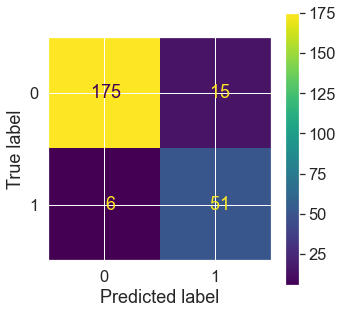

In [52]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       190
           1       0.77      0.89      0.83        57

    accuracy                           0.91       247
   macro avg       0.87      0.91      0.89       247
weighted avg       0.92      0.91      0.92       247



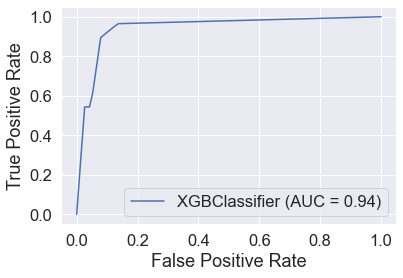

In [54]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

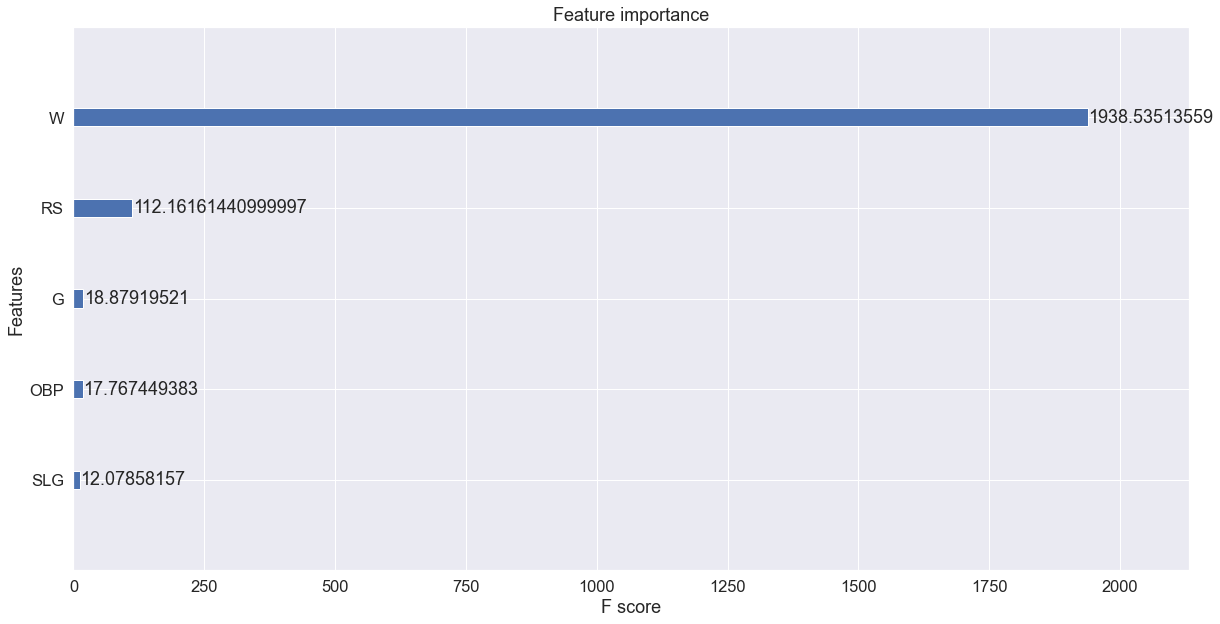

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [56]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [57]:
cv.mean()

0.8904084789835753

### Model Tuning

In [58]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [59]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [60]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, n_jobs=-1,
                           scoring='accuracy')

In [61]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [62]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=8,
              learning rate=0.14, learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=800,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.5, verbosity=1)

In [63]:
randm.best_score_

0.9058194266153187

In [64]:
randm.best_params_

{'subsample': 0.5,
 'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning rate': 0.14,
 'gamma': 8,
 'colsample_bytree': 0.7}

### Final Model

In [65]:
xgbnew = XGBClassifier(random_state=0, n_estimators=700, objective='binary:logistic',max_depth=3,
                      gamma=10, min_child_weight=2,subsample=0.5,learning_rate=0.11,colsample_bytree=0.7)

In [66]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.182186
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.182186
[2]	validation_0-error:0.186235
[3]	validation_0-error:0.17004
[4]	validation_0-error:0.157895
[5]	validation_0-error:0.137652
[6]	validation_0-error:0.129555
[7]	validation_0-error:0.137652
[8]	validation_0-error:0.121457
[9]	validation_0-error:0.125506
[10]	validation_0-error:0.129555
[11]	validation_0-error:0.133603
[12]	validation_0-error:0.129555
[13]	validation_0-error:0.129555
[14]	validation_0-error:0.125506
[15]	validation_0-error:0.125506
[16]	validation_0-error:0.121457
[17]	validation_0-error:0.117409
[18]	validation_0-error:0.121457
[19]	validation_0-error:0.097166
[20]	validation_0-error:0.11336
[21]	validation_0-error:0.11336
[22]	validation_0-error:0.117409
[23]	validation_0-error:0.117409
[24]	validation_0-error:0.121457
[25]	validation_0-error:0.125506
[26]	validation_0-error:0.129555
[27]	validation_0-error:0.129555
[28]	validation_0-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=10,
              learning_rate=0.11, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [67]:
y_pred = xgbnew.predict(X_test)

In [68]:
y_pred

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0], dtype=int64)

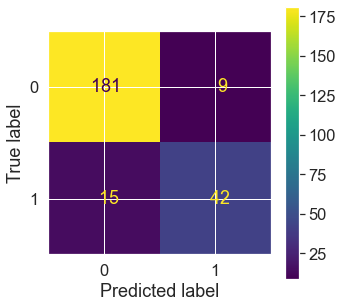

In [69]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [70]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       190
           1       0.82      0.74      0.78        57

    accuracy                           0.90       247
   macro avg       0.87      0.84      0.86       247
weighted avg       0.90      0.90      0.90       247



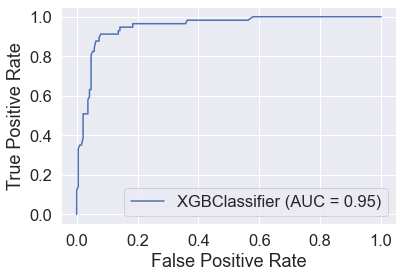

In [71]:
plot_roc_curve(xgbnew,X_test,y_test)
plt.show()